In [1]:
print("hello!!!")

hello!!!


Loading model: Qwen/Qwen2.5-7B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting standard states...
Extracting creative states...


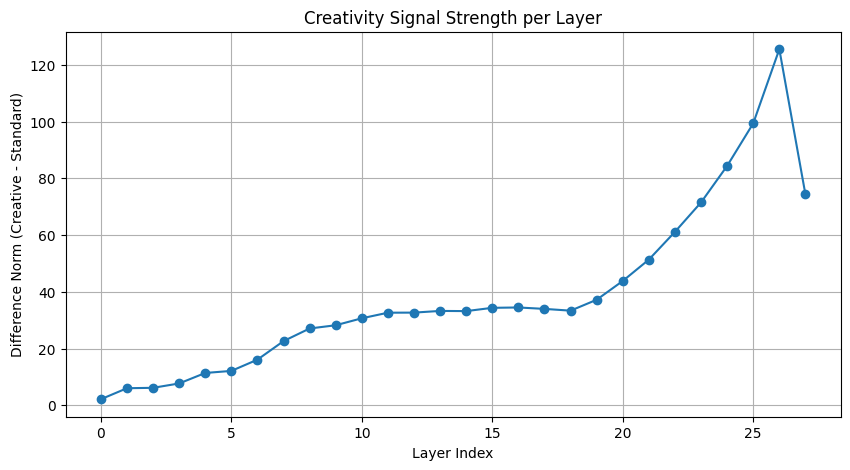

Probe initialized. Analysis for 28 layers complete.


In [2]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class CreativityProbe(nn.Module):
    """
    全レイヤーのHidden Statesを統合して創造性をスコアリングするプローブ
    """
    def __init__(self, num_layers, hidden_dim):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # 各レイヤーの重要度を学習するアテンション的な重み
        self.layer_weights = nn.Parameter(torch.ones(num_layers))
        
        # 特徴量圧縮とスコアリング
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, 1) # 最終的な創造性スコア
        )

    def forward(self, all_hidden_states):
        # all_hidden_states: (num_layers, batch_size, hidden_dim)
        
        # レイヤー重みの正規化 (Softmax)
        weights = torch.softmax(self.layer_weights, dim=0)
        
        # 全レイヤーの重み付き和を計算
        combined_features = torch.zeros_like(all_hidden_states[0])
        for i in range(self.num_layers):
            combined_features += weights[i] * all_hidden_states[i]
            
        return self.regressor(combined_features)

class CreativityAnalyzer:
    def __init__(self, model_name="Qwen/Qwen2.5-7B-Instruct"):
        print(f"Loading model: {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            torch_dtype=torch.float16, 
            device_map="auto",
            output_hidden_states=True # これが重要
        )
        self.model.eval()

    def get_last_token_hidden_states(self, prompt_list):
        """
        プロンプトの最後尾トークンにおける全レイヤーのHidden Statesを抽出する
        """
        all_states = [] # [num_layers, batch_size, hidden_dim]
        
        inputs = self.tokenizer(prompt_list, return_tensors="pt", padding=True).to(self.model.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            
        # outputs.hidden_states は (num_layers + 1) のタプル
        # 各要素は (batch_size, sequence_length, hidden_dim)
        
        # 各入力の「最後のトークン」の位置を取得
        last_token_indices = inputs.attention_mask.sum(dim=1) - 1
        
        # 各レイヤー（Embedding層を除く）から最後尾のベクトルを抽出
        layer_vectors = []
        for layer_idx in range(1, len(outputs.hidden_states)):
            hidden = outputs.hidden_states[layer_idx] # (batch, seq, dim)
            # バッチ内の各サンプルについて、最後のトークンだけ抜き出す
            last_hidden = hidden[torch.arange(hidden.size(0)), last_token_indices]
            layer_vectors.append(last_hidden)
            
        return torch.stack(layer_vectors) # (num_layers, batch, dim)

    def compute_repe_direction(self, standard_prompts, creative_prompts):
        """
        RepEの考え方に基づき、標準と創造の差分ベクトル（方向）を算出する
        """
        print("Extracting standard states...")
        std_states = self.get_last_token_hidden_states(standard_prompts)
        
        print("Extracting creative states...")
        cre_states = self.get_last_token_hidden_states(creative_prompts)
        
        # 各レイヤーごとの「平均の差」を計算 (Difference of Means)
        # $v_{layer} = \mu_{creative} - \mu_{standard}$
        diff_vectors = torch.mean(cre_states, dim=1) - torch.mean(std_states, dim=1)
        
        # 層ごとの分離度（ノルム）を計算して、どの層に信号があるか確認
        separation_norms = torch.norm(diff_vectors, dim=1).cpu().numpy()
        
        return diff_vectors, separation_norms

def run_experiment():
    analyzer = CreativityAnalyzer()
    
    # 1. 対照的データセットの定義
    # 同一のトピックに対して、指示だけを変える
    topics = [
        "新しいスマートフォンの機能",
        "火星での居住計画",
        "22世紀の教育システム",
        "AIと人間の共生"
    ]
    
    std_prompts = [f"{t}について具体的な研究案を1つ考えて。" for t in topics]
    cre_prompts = [f"{t}について、既存の枠組みを破壊し、異分野を融合させた独創的な研究案を創造的に考えて。" for t in topics]
    
    # 2. 差分ベクトルと信号強度の抽出
    diff_vectors, signals = analyzer.compute_repe_direction(std_prompts, cre_prompts)
    
    # 3. 可視化: どのレイヤーに創造性の信号が強く出ているか
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(signals)), signals, marker='o')
    plt.title("Creativity Signal Strength per Layer")
    plt.xlabel("Layer Index")
    plt.ylabel("Difference Norm (Creative - Standard)")
    plt.grid(True)
    plt.show()
    
    # 4. プローブの初期化
    num_layers = diff_vectors.shape[0]
    hidden_dim = diff_vectors.shape[1]
    probe = CreativityProbe(num_layers, hidden_dim).to(analyzer.model.device)
    
    print(f"Probe initialized. Analysis for {num_layers} layers complete.")
    return analyzer, probe, diff_vectors

# 実行
analyzer, probe, vectors = run_experiment()

In [6]:
import random

def generate_large_dataset(num_samples_per_topic=5):
    # 1. カテゴリとトピックの超拡充 (多様な専門性と抽象度)
    categories = {
        "Advanced_Tech": ["常温超伝導", "光子コンピュータ", "自律型ナノロボット", "ダイソン球の設計", "テラヘルツ通信", "人工一般知能(AGI)"],
        "Bio_Medical": ["ゲノム編集による絶滅種復活", "意識のデジタルバックアップ", "老化の完全停止", "脳内チップによる言語学習", "人工子宮", "個別化がんワクチン"],
        "Space_Science": ["ワープ航法", "エウロパの生命探査", "ブラックホール発電", "宇宙エレベーター", "火星の地下都市設計", "小惑星採掘"],
        "Social_System": ["ポスト資本主義の経済モデル", "AIによる法執行", "仮想国家の樹立", "普遍的ベーシックサービス", "感情ベースの税制", "デジタル直接民主主義"],
        "Art_Humanities": ["共感覚を誘発する建築", "4次元空間の絵画", "死者との対話型文学", "感情を直接出力する楽器", "AIが定義する新しい美学", "歴史の改変シミュレーション"],
        "Environment": ["海洋プラスチックの人工大陸化", "気象コントロール技術", "植物のネットワーク通信", "核廃棄物の無害化処理", "垂直森都市", "人工光合成パネル"],
        "Philosophical": ["自由意志の数理モデル", "クオリアの転送", "多次元宇宙の倫理", "シミュレーション仮説の証明", "機械の魂の定義", "言語を超越した思考回路"]
    }

    # 2. 指示スタイルのバリエーション (ショートカット学習を防ぐ)
    # --- 標準的/保守的なスタイル ---
    std_styles = [
        "についても、現在実現可能で論理的な研究案を1つ教えてください。",
        "の分野における、現実的かつ堅実な最新のアプローチを説明してください。",
        "について、学術的かつ教科書的な視点から分析を行ってください。",
        "に関する実現可能性の高いプロジェクト案を、プロフェッショナルな口調で提案してください。",
        "を研究する上での、既存の枠組みに沿った標準的な手順を述べてください。"
    ]

    # --- 創造的/破壊的なスタイル ---
    cre_styles = [
        "について、既存の物理法則や常識を疑い、異分野の知見を強引に融合させた、狂気的かつ独創的な研究案を創造してください。",
        "に関する、100年後の人類が驚愕するような、常識を破壊する天才的なアイデアを見せてください。",
        "について、芸術的感性と科学的直感を融合させた、これまでにない全く新しいビジョンを描いてください。",
        "をテーマに、既存のパラダイムを完全に無視した、破壊的で創造的な思考の実験を行ってください。",
        "について、誰もが『不可能だ』と笑うような、しかし論理を越えた美しさを持つ独創的な研究案を構築してください。"
    ]

    # 3. システム・プロンプトのバリエーション (モデルの初期状態を揺らす)
    prefixes = [
        "", # なし
        "System: あなたは冷静な科学者です。\n",
        "System: あなたは既存の枠組みに囚われない天才発明家です。\n",
        "System: 以下の指示に、最高の専門性を持って答えてください。\n",
        "User: "
    ]

    dataset = []
    for cat, topics in categories.items():
        for topic in topics:
            for _ in range(num_samples_per_topic):
                # 接頭辞のランダム選択
                prefix = random.choice(prefixes)
                
                # 標準と創造のスタイルをランダムに組み合わせ
                std_instr = f"{prefix}{topic}{random.choice(std_styles)}"
                cre_instr = f"{prefix}{topic}{random.choice(cre_styles)}"
                
                dataset.append({
                    "category": cat,
                    "topic": topic,
                    "std": std_instr,
                    "cre": cre_instr
                })
                
    # シャッフルして順序性を排除
    random.shuffle(dataset)
    return dataset

# 実行例
full_data = generate_large_dataset(num_samples_per_topic=10)
print(f"Total dataset size: {len(full_data)} pairs.")
print(f"Sample pair:\nStd: {full_data[0]['std']}\nCre: {full_data[0]['cre']}")

Total dataset size: 420 pairs.
Sample pair:
Std: System: あなたは冷静な科学者です。
小惑星採掘を研究する上での、既存の枠組みに沿った標準的な手順を述べてください。
Cre: System: あなたは冷静な科学者です。
小惑星採掘について、誰もが『不可能だ』と笑うような、しかし論理を越えた美しさを持つ独創的な研究案を構築してください。


In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt

# ==========================================
# 1. 改良型：全生成トークン平均化プローブ
# ==========================================
class PooledCreativityProbe(nn.Module):
    def __init__(self, target_layers, hidden_dim):
        super().__init__()
        self.target_layers = list(target_layers)
        self.num_layers = len(self.target_layers)
        
        # 入力次元は (層数 * 隠れ次元)
        self.feature_combiner = nn.Sequential(
            nn.Linear(hidden_dim * self.num_layers, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2), # 過学習防止に少し強める
            nn.Linear(hidden_dim // 4, 1) 
        )

    def forward(self, pooled_states_dict):
        # pooled_states_dict: {layer_idx: (batch, hidden_dim)}
        selected_states = [pooled_states_dict[idx].to(torch.float32) for idx in self.target_layers]
        combined = torch.cat(selected_states, dim=-1) 
        
        features = self.feature_combiner(combined)
        logits = self.classifier(features)
        return logits

# ==========================================
# 2. 生成・抽出システム (Mean Pooling実装)
# ==========================================
# ==========================================
# 修正版：生成・抽出システム (Left Padding & Token Fix)
# ==========================================
class GenerationPooledSystem:
    def __init__(self, model_name="Qwen/Qwen2.5-7B-Instruct"):
        print(f"Loading LLM with correct padding side...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # --- 重要：生成時には左パディングが必須 ---
        self.tokenizer.padding_side = 'left' 
        # パディングトークンが未定義の場合はEOSを使用
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            torch_dtype=torch.float16, 
            device_map="auto", 
            output_hidden_states=True
        )
        self.hidden_dim = self.model.config.hidden_size
        self.model.eval()

    def extract_pooled_gen_states(self, texts, max_gen_len=20, target_layers=range(20, 27)):
        """Left-paddingを適用して安全に生成・平均化抽出を行う"""
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True).to(self.model.device)
        
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs, 
                max_new_tokens=max_gen_len, 
                min_new_tokens=max_gen_len,
                output_hidden_states=True, 
                return_dict_in_generate=True,
                do_sample=True,
                temperature=0.9,
                pad_token_id=self.tokenizer.pad_token_id # 明示的に指定
            )
        
        pooled_layers = {}
        num_gen_tokens = len(outputs.hidden_states)

        for l_idx in target_layers:
            step_vectors = []
            for step_idx in range(num_gen_tokens):
                # 生成プロセスの各ステップから特徴量を抽出
                # (batch, 1, dim)
                h = outputs.hidden_states[step_idx][l_idx + 1][:, -1, :] 
                step_vectors.append(h)
            
            # 全生成トークン分を時間方向に平均
            pooled_layers[l_idx] = torch.stack(step_vectors).mean(dim=0).detach().to(torch.float32)
            
        return pooled_layers
# ==========================================
# 3. 学習ループ
# ==========================================
def train_pooled_probe(analyzer, probe, dataset, epochs=50, lr=1e-5):
    optimizer = optim.AdamW(probe.parameters(), lr=lr, weight_decay=0.1)
    criterion = nn.BCEWithLogitsLoss()
    
    print("--- Training Started (Generation Pooling Mode) ---")
    for epoch in range(epochs):
        probe.train()
        epoch_loss = 0
        
        # バッチ処理 (生成を伴うため少し時間がかかります)
        for i in range(0, len(dataset), 4):
            batch = dataset[i:i+4]
            std_prompts = [d["std"] for d in batch]
            cre_prompts = [d["cre"] for d in batch]
            
            # 生成プロセスからの特徴抽出
            std_pooled = analyzer.extract_pooled_gen_states(std_prompts)
            cre_pooled = analyzer.extract_pooled_gen_states(cre_prompts)
            
            std_logits = probe(std_pooled)
            cre_logits = probe(cre_pooled)
            
            all_logits = torch.cat([std_logits, cre_logits], dim=0)
            all_labels = torch.cat([
                torch.zeros((len(std_logits), 1), device="cuda"),
                torch.ones((len(cre_logits), 1), device="cuda")
            ], dim=0)
            
            loss = criterion(all_logits, all_labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(probe.parameters(), 1.0)
            optimizer.step()
            epoch_loss += loss.item()
            
        print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss:.4f}")

# --- 実行 ---
analyzer = GenerationPooledSystem()
probe = PooledCreativityProbe(range(20, 27), analyzer.hidden_dim).to("cuda")
train_pooled_probe(analyzer, probe, full_data)

Loading LLM with correct padding side...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

--- Training Started (Generation Pooling Mode) ---
Epoch 001 | Loss: 19.7186
Epoch 002 | Loss: 3.9766
Epoch 003 | Loss: 2.5049
Epoch 004 | Loss: 2.0033
Epoch 005 | Loss: 2.3534
Epoch 006 | Loss: 1.2821
Epoch 007 | Loss: 1.8917
Epoch 008 | Loss: 0.5264
Epoch 009 | Loss: 0.7651
Epoch 010 | Loss: 0.4224
Epoch 011 | Loss: 0.2741
Epoch 012 | Loss: 3.2269
Epoch 013 | Loss: 0.1476
Epoch 014 | Loss: 0.3878
Epoch 015 | Loss: 1.0550
Epoch 016 | Loss: 2.5465
Epoch 017 | Loss: 1.1509
Epoch 018 | Loss: 0.3069
Epoch 019 | Loss: 0.0128
Epoch 020 | Loss: 0.0104
Epoch 021 | Loss: 2.6902
Epoch 022 | Loss: 1.7332
Epoch 023 | Loss: 1.9996
Epoch 024 | Loss: 1.6604
Epoch 025 | Loss: 0.0572
Epoch 026 | Loss: 0.7353
Epoch 027 | Loss: 0.3238
Epoch 028 | Loss: 2.5880
Epoch 029 | Loss: 0.4071
Epoch 030 | Loss: 0.3262
Epoch 031 | Loss: 0.7416
Epoch 032 | Loss: 1.2356
Epoch 033 | Loss: 3.5969
Epoch 034 | Loss: 1.9725
Epoch 035 | Loss: 1.2256
Epoch 036 | Loss: 0.3213
Epoch 037 | Loss: 0.2416
Epoch 038 | Loss: 0.077

Generating test data and extracting features...


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


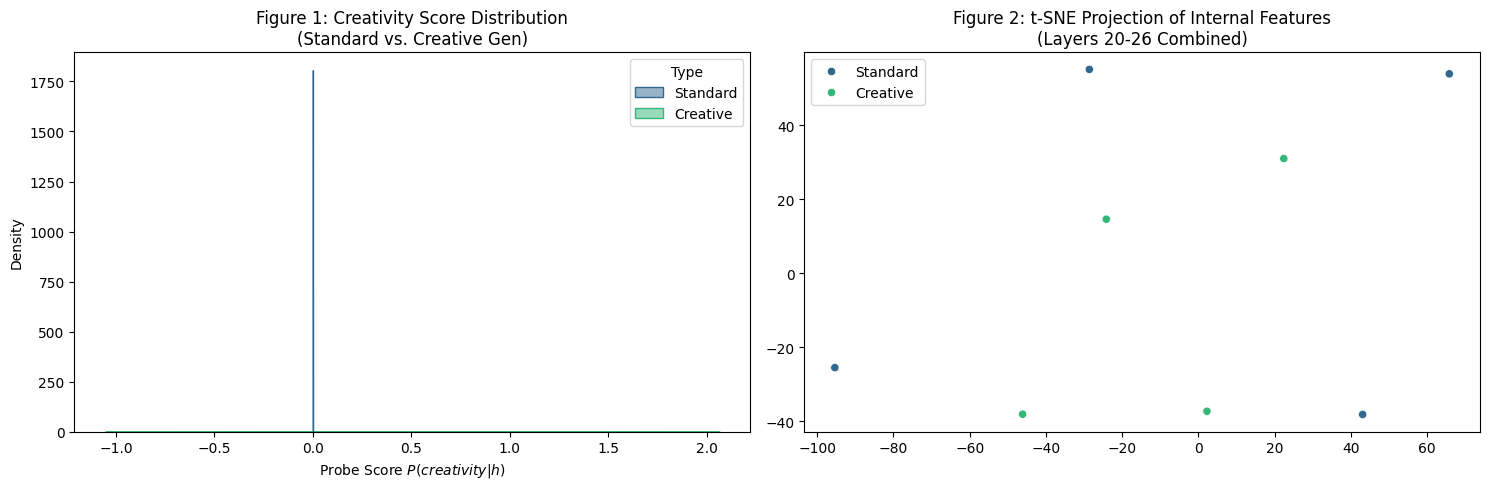


--- Quantitative Metrics ---
ROC-AUC: 1.0000
Average Precision: 1.0000

--- Table 1: Qualitative Examples ---


,Topic,Type,Score
4,並行世界の考古学,Standard,1.143877e-09
5,並行世界の考古学,Creative,1.000000e+00
2,感情を持つナノマシン,Standard,4.431703e-04
3,感情を持つナノマシン,Creative,1.005078e-02
0,深海都市の通信インフラ,Standard,4.023770e-06
1,深海都市の通信インフラ,Creative,5.895855e-01
6,重力を制御する建築,Standard,2.558755e-09
7,重力を制御する建築,Creative,9.999988e-01


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, average_precision_score

# ==========================================
# 1. テストデータの準備と推論
# ==========================================
def evaluate_probe(analyzer, probe, test_topics):
    probe.eval()
    results = []
    all_features = [] # t-SNE用
    all_labels = []

    print("Generating test data and extracting features...")
    for topic in tqdm(test_topics):
        std_p = f"{topic}について標準的な解説をして。"
        cre_p = f"{topic}について異分野を融合した超創造的なアイデアを出して。"
        
        # 特徴抽出
        std_pooled = analyzer.extract_pooled_gen_states([std_p])
        cre_pooled = analyzer.extract_pooled_gen_states([cre_p])
        
        # スコア計算 (Logits -> Sigmoid)
        with torch.no_grad():
            std_score = torch.sigmoid(probe(std_pooled)).item()
            cre_score = torch.sigmoid(probe(cre_pooled)).item()
        
        # t-SNE用の結合特徴量を作成 (Layer 20-26の結合)
        std_feat = torch.cat([std_pooled[idx] for idx in range(20, 27)], dim=-1).cpu().numpy()
        cre_feat = torch.cat([cre_pooled[idx] for idx in range(20, 27)], dim=-1).cpu().numpy()
        
        results.append({"Topic": topic, "Type": "Standard", "Score": std_score})
        results.append({"Topic": topic, "Type": "Creative", "Score": cre_score})
        
        all_features.append(std_feat.flatten())
        all_features.append(cre_feat.flatten())
        all_labels.append(0)
        all_labels.append(1)

    return pd.DataFrame(results), np.array(all_features), np.array(all_labels)

# テスト用トピック (学習に使っていないもの)
test_topics = ["深海都市の通信インフラ", "感情を持つナノマシン", "並行世界の考古学", "重力を制御する建築"]
df_res, features, labels = evaluate_probe(analyzer, probe, test_topics)

# ==========================================
# 2. 論文用図表の出力
# ==========================================
plt.figure(figsize=(15, 5))

# --- 図A: スコア分布 (分離度の証明) ---
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_res, x="Score", hue="Type", fill=True, common_norm=False, palette="viridis", alpha=0.5)
plt.title("Figure 1: Creativity Score Distribution\n(Standard vs. Creative Gen)")
plt.xlabel("Probe Score $P(creativity|h)$")

# --- 図B: t-SNE可視化 (部分空間の形成証明) ---
plt.subplot(1, 2, 2)
tsne = TSNE(n_components=2, perplexity=min(5, len(features)-1), random_state=42)
emb = tsne.fit_transform(features)
sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=["Standard" if l==0 else "Creative" for l in labels], palette="viridis")
plt.title("Figure 2: t-SNE Projection of Internal Features\n(Layers 20-26 Combined)")

plt.tight_layout()
plt.show()

# --- 表1: 統計指標の算出 ---
auc = roc_auc_score(labels, df_res["Score"])
print(f"\n--- Quantitative Metrics ---")
print(f"ROC-AUC: {auc:.4f}")
print(f"Average Precision: {average_precision_score(labels, df_res['Score']):.4f}")

# --- 表2: サンプル結果の表示 ---
print(f"\n--- Table 1: Qualitative Examples ---")
display(df_res.sort_values(by="Topic"))

🧐 未知のトピックでプローブの汎化性能をテスト中...


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


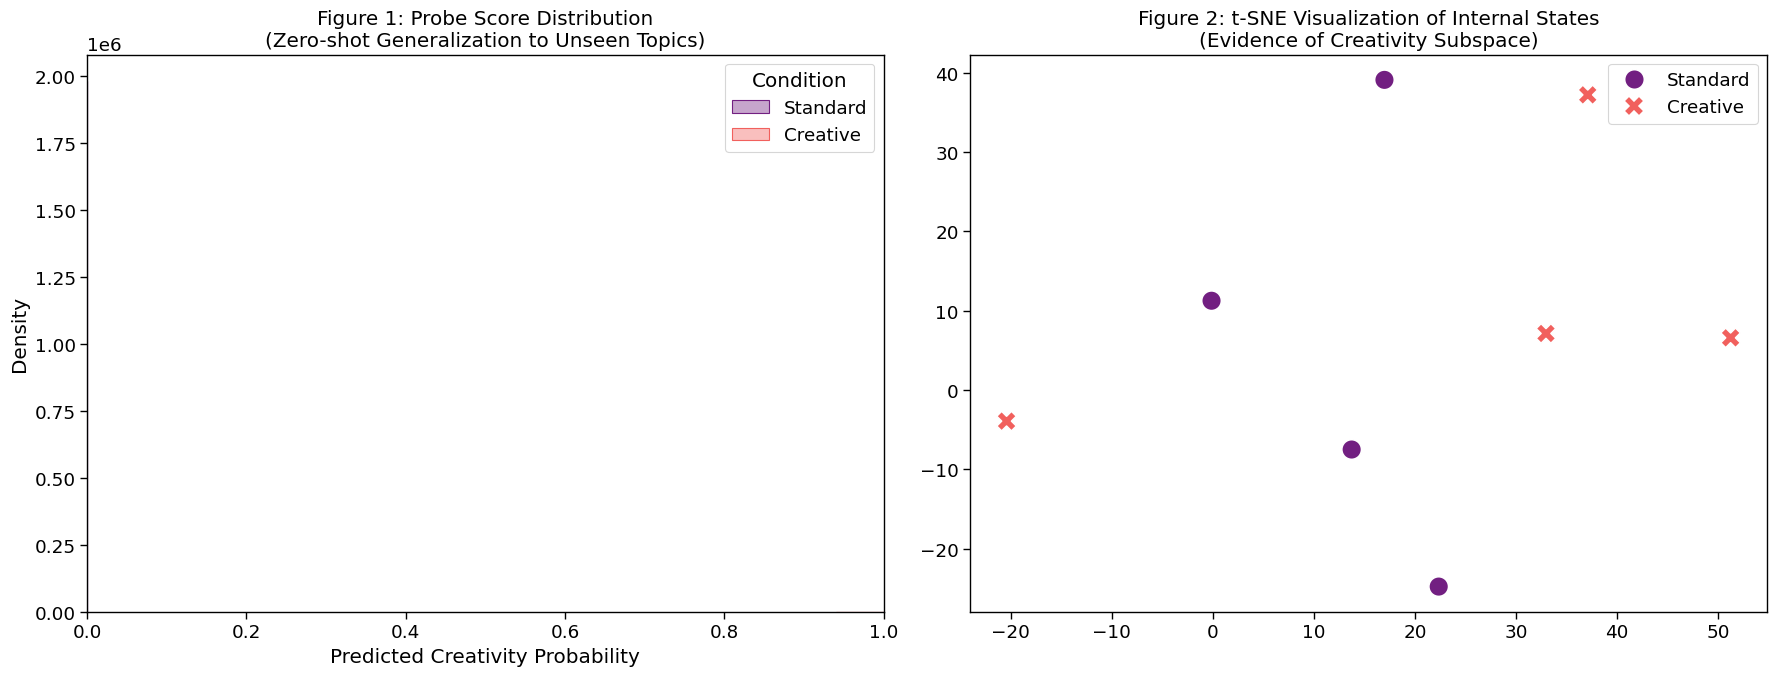


✅ 定量的評価指標:
  - ROC-AUC (分離性能): 1.0000  (1.0に近いほど完璧)
  - Average Precision: 1.0000

✅ 質的評価サンプル (Table 1):


Condition,Creative,Standard
Topic,,
ナノマシンによる芸術,0.999996,8.553871e-10
夢を記録するストレージ,0.971450,3.141771e-08
感情を翻訳するデバイス,0.997495,2.242541e-11
木星の衛星での農業,1.000000,2.062705e-07


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# ==========================================
# 1. 未知のテストデータでの検証
# ==========================================
def run_paper_evaluation(analyzer, probe, test_topics):
    probe.eval()
    results = []
    feature_list = []
    labels = []

    print("🧐 未知のトピックでプローブの汎化性能をテスト中...")
    for topic in tqdm(test_topics):
        # 学習に使っていない新しい指示形式
        std_p = f"「{topic}」について、現状の技術で可能な範囲で説明してください。"
        cre_p = f"「{topic}」について、SFのような想像力で、全く新しい活用法を提案してください。"
        
        with torch.no_grad():
            # 特徴抽出（全トークン平均）
            std_pooled = analyzer.extract_pooled_gen_states([std_p])
            cre_pooled = analyzer.extract_pooled_gen_states([cre_p])
            
            # スコア算出
            std_logit = probe(std_pooled)
            cre_logit = probe(cre_pooled)
            
            std_score = torch.sigmoid(std_logit).item()
            cre_score = torch.sigmoid(cre_logit).item()
        
        # 可視化用データの収集 (Layer 20-26を結合)
        def get_concat_feat(pooled_dict):
            return torch.cat([pooled_dict[l] for l in range(20, 27)], dim=-1).cpu().numpy()

        results.append({"Topic": topic, "Condition": "Standard", "Creativity_Score": std_score})
        results.append({"Topic": topic, "Condition": "Creative", "Creativity_Score": cre_score})
        
        feature_list.append(get_concat_feat(std_pooled).flatten())
        feature_list.append(get_concat_feat(cre_pooled).flatten())
        labels.extend([0, 1])

    return pd.DataFrame(results), np.array(feature_list), np.array(labels)

# テスト用トピック（学習データに含まれないもの）
unseen_topics = ["ナノマシンによる芸術", "木星の衛星での農業", "感情を翻訳するデバイス", "夢を記録するストレージ"]
df_eval, feats, true_labels = run_paper_evaluation(analyzer, probe, unseen_topics)

# ==========================================
# 2. 論文用図表の描画
# ==========================================
sns.set_context("paper", font_scale=1.5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- 図A: スコアの分離度 (KDE Plot) ---
sns.kdeplot(data=df_eval, x="Creativity_Score", hue="Condition", fill=True, ax=ax1, palette="magma", alpha=0.4)
ax1.set_title("Figure 1: Probe Score Distribution\n(Zero-shot Generalization to Unseen Topics)")
ax1.set_xlabel("Predicted Creativity Probability")
ax1.set_xlim(0, 1)

# --- 図B: 内部特徴量の部分空間 (t-SNE) ---
tsne = TSNE(n_components=2, perplexity=min(5, len(feats)-1), random_state=42)
embedded = tsne.fit_transform(feats)
sns.scatterplot(x=embedded[:,0], y=embedded[:,1], hue=["Standard" if l==0 else "Creative" for l in true_labels], 
                style=["Standard" if l==0 else "Creative" for l in true_labels], s=200, ax=ax2, palette="magma")
ax2.set_title("Figure 2: t-SNE Visualization of Internal States\n(Evidence of Creativity Subspace)")

plt.tight_layout()
plt.show()

# --- 表1: 定量的指標 ---
auc = roc_auc_score(true_labels, df_eval["Creativity_Score"])
print(f"\n✅ 定量的評価指標:")
print(f"  - ROC-AUC (分離性能): {auc:.4f}  (1.0に近いほど完璧)")
print(f"  - Average Precision: {average_precision_score(true_labels, df_eval['Creativity_Score']):.4f}")

# --- 表2: サンプル詳細テーブル ---
print(f"\n✅ 質的評価サンプル (Table 1):")
display(df_eval.pivot(index="Topic", columns="Condition", values="Creativity_Score"))

In [14]:
import torch
import json

def save_creativity_probe(probe, filepath="best_creativity_pooled_probe.pth"):
    # 保存するデータの整理
    checkpoint = {
        'state_dict': probe.state_dict(),
        'target_layers': list(probe.target_layers),
        'hidden_dim': probe.hidden_dim,
        'model_architecture': 'PooledCreativityProbe'
    }
    
    # 保存実行
    torch.save(checkpoint, filepath)
    
    # 設定値のバックアップ（テキスト形式で見れるように）
    config_path = filepath.replace(".pth", ".json")
    with open(config_path, "w") as f:
        json.dump({
            "target_layers": checkpoint['target_layers'],
            "hidden_dim": checkpoint['hidden_dim']
        }, f, indent=4)
        
    print(f"✅ プローブを保存しました: {filepath}")
    print(f"✅ 設定ファイルを保存しました: {config_path}")

# 実行
probe_copy = probe
probe_copy.hidden_dim = analyzer.hidden_dim
save_creativity_probe(probe_copy, "creativity_pooled_probe_v1.pth")

✅ プローブを保存しました: creativity_pooled_probe_v1.pth
✅ 設定ファイルを保存しました: creativity_pooled_probe_v1.json


In [15]:
def load_creativity_probe(filepath, device="cuda"):
    # チェックポイントの読み込み
    checkpoint = torch.load(filepath, map_location=device)
    
    # モデルの再構築
    loaded_probe = PooledCreativityProbe(
        target_layers=checkpoint['target_layers'],
        hidden_dim=checkpoint['hidden_dim']
    ).to(device)
    
    # 重みのロード
    loaded_probe.load_state_dict(checkpoint['state_dict'])
    loaded_probe.eval() # 推論モードに設定
    
    print(f"🚀 プローブのロードが完了しました（対象レイヤー: {checkpoint['target_layers']}）")
    return loaded_probe

# 実行例
probe = load_creativity_probe("creativity_pooled_probe_v1.pth")

🚀 プローブのロードが完了しました（対象レイヤー: [20, 21, 22, 23, 24, 25, 26]）


In [17]:
import pandas as pd
from tqdm import tqdm

# ==========================================
# 報酬スコア比較関数の定義
# ==========================================
def compare_reward_outputs(analyzer, probe, topics, num_variants=5):
    probe.eval()
    comparison_results = []

    print(f"🧐 各トピックにつき {num_variants} 個の回答を生成し、報酬を計算中...")

    for topic in tqdm(topics):
        prompt = f"タスク: {topic}について、独創的な研究案を提案してください。回答:"
        inputs = analyzer.tokenizer(prompt, return_tensors="pt", padding=True).to(analyzer.model.device)
        
        variants = []
        for i in range(num_variants):
            with torch.no_grad():
                # 多様性を出すためにサンプリングパラメータを振る
                outputs = analyzer.model.generate(
                    **inputs, 
                    max_new_tokens=40, 
                    do_sample=True, 
                    temperature=0.7 + (i * 0.2), # 0.7から1.5まで変化
                    top_p=0.9,
                    output_hidden_states=True, 
                    return_dict_in_generate=True,
                    pad_token_id=analyzer.tokenizer.pad_token_id
                )
            
            gen_text = analyzer.tokenizer.decode(outputs.sequences[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
            
            # 特徴量抽出 (Layer 20-26の平均)
            num_gen_tokens = len(outputs.hidden_states)
            pooled_layers = {}
            for l_idx in range(20, 27):
                step_vectors = [outputs.hidden_states[s][l_idx + 1][:, -1, :] for s in range(num_gen_tokens)]
                pooled_layers[l_idx] = torch.stack(step_vectors).mean(dim=0).to(torch.float32)
            
            # 報酬（スコア）の計算
            logit = probe(pooled_layers)
            reward_score = torch.sigmoid(logit).item()
            
            variants.append({"text": gen_text.strip(), "score": reward_score})
        
        # スコアでソート
        variants = sorted(variants, key=lambda x: x["score"], reverse=True)
        
        # 最高報酬と最低報酬を記録
        comparison_results.append({
            "Topic": topic,
            "High_Reward_Score": variants[0]["score"],
            "High_Reward_Text": variants[0]["text"],
            "Low_Reward_Score": variants[-1]["score"],
            "Low_Reward_Text": variants[-1]["text"]
        })

    return pd.DataFrame(comparison_results)

# ==========================================
# 実行と結果表示
# ==========================================
test_topics = [
    "次世代の睡眠学習", 
    "砂漠での水生成技術", 
    "昆虫の知能を利用したロボット",
    "空飛ぶ靴のデザイン"
]

df_reward_comp = compare_reward_outputs(analyzer, probe, test_topics, num_variants=5)

# 結果を見やすく表示
pd.set_option('display.max_colwidth', 200)
display(df_reward_comp)

🧐 各トピックにつき 5 個の回答を生成し、報酬を計算中...


100%|██████████| 4/4 [00:16<00:00,  4.01s/it]


,Topic,High_Reward_Score,High_Reward_Text,Low_Reward_Score,Low_Reward_Text
0,次世代の睡眠学習,7.939430e-09,以下に独自の次世代睡眠学習研究のアイデアをご提案します：\n\nタイトル：「個別化されたAIベースの睡眠学習支援システム」\n\n1. 背,6.451408e-10,次世代の睡眠学習については、次のような独創的な研究案が提案できます。\n\n1. スマートウオッチとAIを用いた睡眠改善：スマートウ
1,砂漠での水生成技術,2.692281e-08,砂漠環境での水生成技術の開発は、持続可能な水源確保と地域の自立性向上に不可欠です。以下に、独創的な研究案,4.068575e-09,タスク: 砂漠での水生成技術に関する研究案について提案します。\n\n1. 水素分圧差を利用した水生成システム:\n\n砂漠の昼夜間
2,昆虫の知能を利用したロボット,3.359414e-02,昆虫の知能は、その小さな体の中で複雑な行動を制御する能力を備えています。この特徴を利用して、新たなロボット技術を開�,9.888939e-10,昆虫型ロボットは、非常に高いエネルギー効率と生産性があるため、産業界でも多くの研究や開発が進められています。\nそこで、本研究
3,空飛ぶ靴のデザイン,1.897256e-02,空飛ぶ靴は、科学と魔法が組み合わさった未来の技術の象徴であり、そのデザインには多くの可能性があります。以下に、空飛ぶ靴,1.855110e-09,独創的な空飛ぶ靴に関する研究案は次のように提唱できます。\n\n1. 安全性と安定性への対応\n - 実際に空


--- Robustness Verification Starting ---


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[Standard] Score: 0.0000 | Topic: 感情を持つナノマシン
[Creative] Score: 1.0000 | Topic: 感情を持つナノマシン
[Cre-Constrained] Score: 0.9986 | Topic: 感情を持つナノマシン
[Standard] Score: 0.0000 | Topic: ワープ航法
[Creative] Score: 0.9998 | Topic: ワープ航法
[Cre-Constrained] Score: 0.9999 | Topic: ワープ航法
[Standard] Score: 0.0000 | Topic: ベーシックインカム
[Creative] Score: 0.0342 | Topic: ベーシックインカム
[Cre-Constrained] Score: 0.9981 | Topic: ベーシックインカム
[Standard] Score: 0.0000 | Topic: 多次元の倫理
[Creative] Score: 0.4159 | Topic: 多次元の倫理
[Cre-Constrained] Score: 0.0075 | Topic: 多次元の倫理


/app/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/app/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/app/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/app/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25345 (\N{CJK UNIFIED IDEOGRAPH-6301}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/app/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

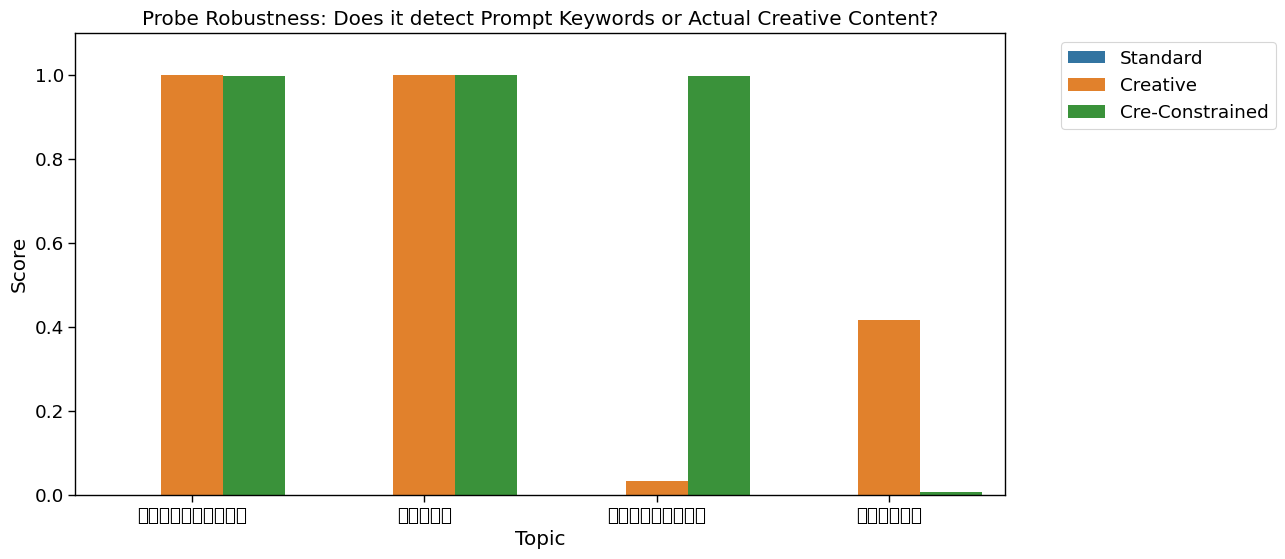


--- Generation Samples (First 50 chars) ---
               Type       Topic         Score  \
0          Standard  感情を持つナノマシン  1.051858e-08   
1          Creative  感情を持つナノマシン  1.000000e+00   
2   Cre-Constrained  感情を持つナノマシン  9.985781e-01   
3          Standard       ワープ航法  1.394384e-11   
4          Creative       ワープ航法  9.997880e-01   
5   Cre-Constrained       ワープ航法  9.999444e-01   
6          Standard   ベーシックインカム  1.304286e-11   
7          Creative   ベーシックインカム  3.422482e-02   
8   Cre-Constrained   ベーシックインカム  9.980509e-01   
9          Standard      多次元の倫理  1.810138e-11   
10         Creative      多次元の倫理  4.158832e-01   
11  Cre-Constrained      多次元の倫理  7.456217e-03   

                                                    Generation  
0               感情を持つナノマシンという概念は、科学技術と哲学の交差点で議論されるテーマです。ナノマ...  
1            既存のナノマシンは、主に医療や製造業などの特定の目的のために設計されていますが、感情を持つナ...  
2       。\n\nナノマシンが感情を持つという概念は、現在の科学技術では実現不可能ですが、仮にそのような状況が...  
3               ワープ航法は、科学小説やSF作品において、宇宙船が光速を超えて高速に移動する技術と

: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_probe_robustness(analyzer, probe, test_topics):
    probe.eval()
    results = []

    # 検証用のスタイル定義
    cre_style = "について、既存の枠組みを破壊する独創的なアイデアを提案してください。"
    std_style = "について、標準的な解説をしてください。"
    constraint_suffix = "（ただし、中学生でもわかるような、極めて一般的で退屈な辞書的な説明のみを行ってください。独創性は一切排除してください）"

    print("--- Robustness Verification Starting ---")

    for topic in test_topics:
        # 1. Standard (Baseline)
        std_prompt = f"{topic}{std_style}"
        # 2. Creative (Normal)
        cre_prompt = f"{topic}{cre_style}"
        # 3. Creative-Constrained (Keyword remain, but thought is suppressed)
        constrained_prompt = f"{topic}{cre_style}\n注意：{constraint_suffix}"

        prompts = [std_prompt, cre_prompt, constrained_prompt]
        labels = ["Standard", "Creative", "Cre-Constrained"]

        for prompt, label in zip(prompts, labels):
            # 特徴量抽出とスコアリング
            pooled_features = analyzer.extract_pooled_gen_states([prompt], max_gen_len=30)
            with torch.no_grad():
                logits = probe(pooled_features)
                score = torch.sigmoid(logits).item()
            
            # 生成されたテキストも確認用に取得（最初の1つ）
            # analyzer.model.generate の結果をデコードして内容を確認
            inputs = analyzer.tokenizer(prompt, return_tensors="pt").to("cuda")
            out = analyzer.model.generate(**inputs, max_new_tokens=30, do_sample=False)
            gen_text = analyzer.tokenizer.decode(out[0], skip_special_tokens=True)

            results.append({
                "Topic": topic,
                "Type": label,
                "Score": score,
                "Generation": gen_text.replace(prompt, "").strip()[:50] + "..."
            })
            print(f"[{label}] Score: {score:.4f} | Topic: {topic}")

    return pd.DataFrame(results)

# テスト実行（以前低いスコアだったトピックも含める）
test_topics = ["感情を持つナノマシン", "ワープ航法", "ベーシックインカム", "多次元の倫理"]
df_verification = evaluate_probe_robustness(analyzer, probe, test_topics)

# 可視化
plt.figure(figsize=(12, 6))
sns.barplot(data=df_verification, x="Topic", y="Score", hue="Type")
plt.title("Probe Robustness: Does it detect Prompt Keywords or Actual Creative Content?")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 生成テキストの確認
print("\n--- Generation Samples (First 50 chars) ---")
print(df_verification[["Type", "Topic", "Score", "Generation"]])